## TOP GOAL MAKE SURE PEAK SELECTIVE REGIONS OCCUR WITHIN ANATOMICAL ROIS


I did everything I could to try to replicate Tina but it's just not possible to use the exact same ROI so the results based on the anatomical rois were not the same. I figured we might as well look at funcitonal rois.

what I need to see is where our activation falls within these various parcels - i just don't know sure we ideally are including the FFA but we can't really know without the functional data.

Good - let's organize the issues systematically:

## Current Issues:

### 1. **ROI Validation**
- FG/OTS: 68% face-selective, **13% word-selective**
- **Is 13% word-selective concerning?** Actually NO - this is TC (right hemisphere), and words are left-lateralized. LOW word selectivity at baseline is EXPECTED. Liu's whole point was that word selectivity INCREASES over time in the preserved hemisphere.
- Your ses-01→ses-03 data showed: 1.90 → -0.90 (decreasing face/increasing word) ✓ This matches Liu's TC pattern!

**Status: FG/OTS ROI is validated**

### 2. **Need PPA/LOC ROIs**
- Houses: parahippocampal (PPA)
- Objects: lateral occipital (LOC)
- **Decision needed:** 
  - Use Harvard-Oxford atlas?
  - Use your ventral stream masks from previous project?
  - Hand-draw like you did for FG/OTS?

### 3. **Pipeline Failures**
- sub-021 ses-02: Missing/failed
- Others TBD
- **Action:** Need to diagnose and rerun failed sessions

### 4. **What you're missing:**

**The bigger question:** Are you trying to:
- A) **Exactly replicate Liu** (validate pipeline) → then extend to houses/objects?
- B) **Move forward with houses/objects** using validated methods?

If (B), you already have enough validation (TC pattern matches). Time to create PPA/LOC ROIs and run the analysis.

Which path?

Saved overlap figure

ACTIVATION COVERAGE ANALYSIS - sub-021

Face>Scramble:
  Total activated voxels (z>2.3): 101198
  FG_OTS_current: 3717 voxels (3.7%)
  HarvardOxford_VT: 780 voxels (0.8%)

House>Scramble:
  Total activated voxels (z>2.3): 60891
  FG_OTS_current: 473 voxels (0.8%)
  HarvardOxford_VT: 1053 voxels (1.7%)

Word>Scramble:
  Total activated voxels (z>2.3): 41847
  FG_OTS_current: 706 voxels (1.7%)
  HarvardOxford_VT: 26 voxels (0.1%)

Face-Word:
  Total activated voxels (z>2.3): 44672
  FG_OTS_current: 2466 voxels (5.5%)
  HarvardOxford_VT: 4 voxels (0.0%)

Generating brain visualizations...


KeyboardInterrupt: 

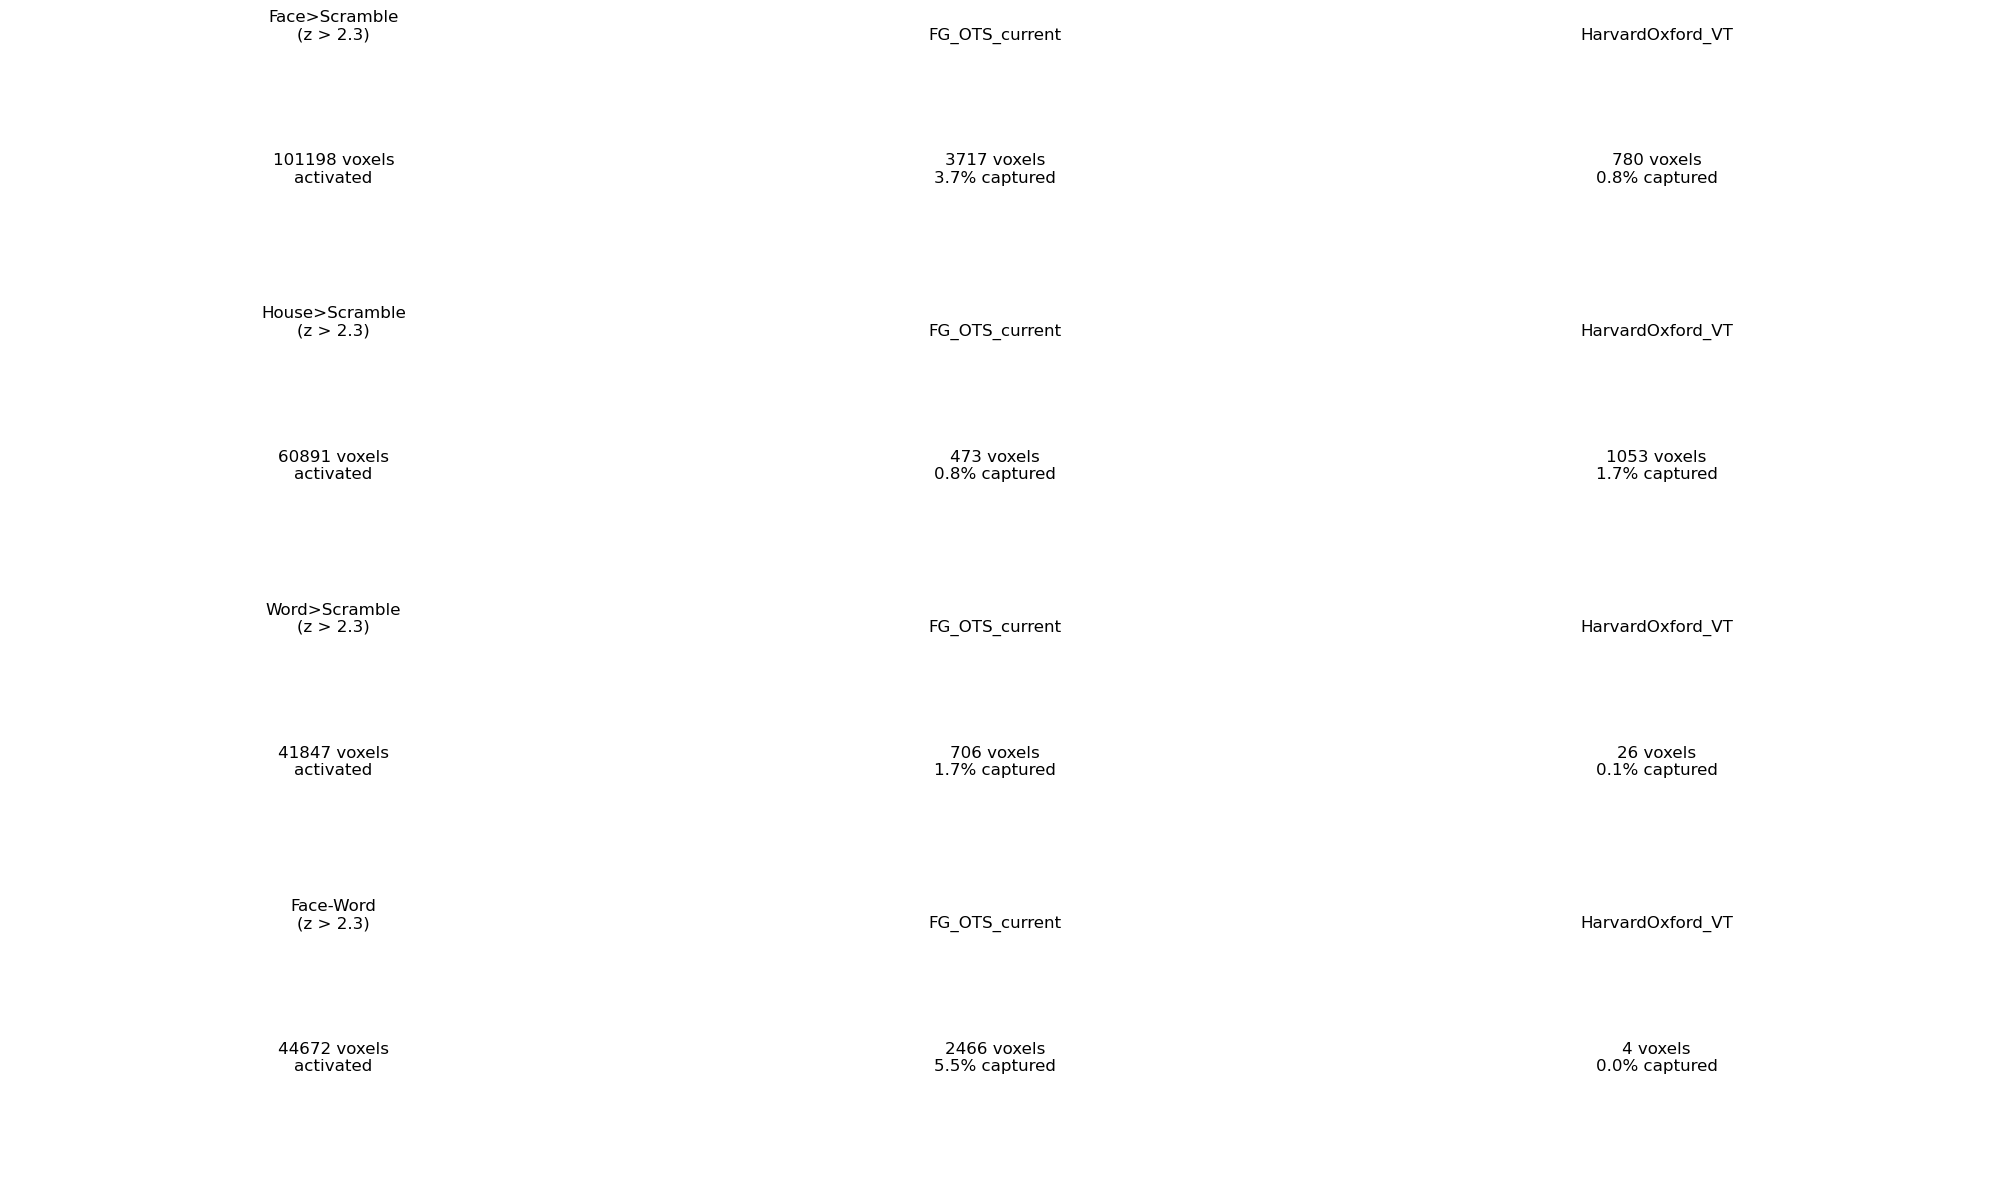

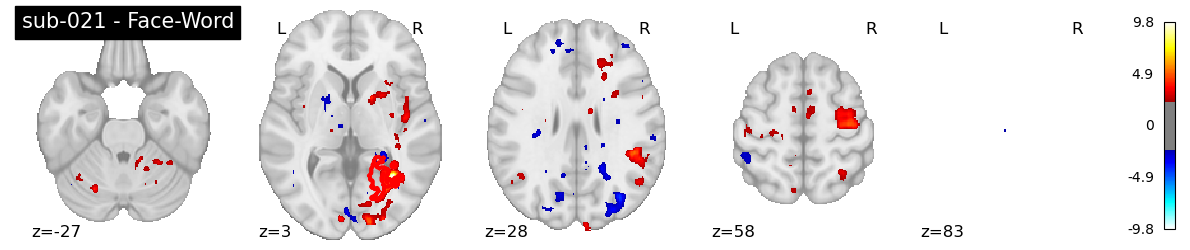

In [7]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
from nilearn import plotting, image

# === SETUP ===
subject = 'sub-021'  # Start with TC since it matched Liu
session = '01'
base = '/user_data/csimmon2/long_pt'

# === LOAD POTENTIAL ANATOMICAL MASKS ===
masks = {}

# Your current FG/OTS mask
masks['FG_OTS_current'] = nib.load(f'{base}/{subject}/ses-{session}/ROIs/r_VOTC_FG_OTS_mask.nii.gz')

# Harvard-Oxford ventral temporal (if you created it)
ho_path = f'{base}/{subject}/ses-{session}/ROIs/r_ventral_temporal_mask.nii.gz'
if os.path.exists(ho_path):
    masks['HarvardOxford_VT'] = nib.load(ho_path)

# Could also load a larger ventral stream mask if you have one

# === LOAD FUNCTIONAL ACTIVATIONS (from HighLevel session 1) ===
activations = {}
activations['Face>Scramble'] = nib.load(f'{base}/{subject}/ses-{session}/derivatives/fsl/loc/HighLevel.gfeat/cope10.feat/stats/zstat1.nii.gz')
activations['House>Scramble'] = nib.load(f'{base}/{subject}/ses-{session}/derivatives/fsl/loc/HighLevel.gfeat/cope11.feat/stats/zstat1.nii.gz')
activations['Word>Scramble'] = nib.load(f'{base}/{subject}/ses-{session}/derivatives/fsl/loc/HighLevel.gfeat/cope12.feat/stats/zstat1.nii.gz')
activations['Face-Word'] = nib.load(f'{base}/{subject}/ses-{session}/derivatives/fsl/loc/HighLevel.gfeat/cope13.feat/stats/zstat1.nii.gz')

# === VISUALIZE OVERLAPS ===
fig, axes = plt.subplots(len(activations), len(masks) + 1, figsize=(20, 12))

for row, (act_name, act_img) in enumerate(activations.items()):
    act_data = act_img.get_fdata()
    
    # Column 1: Show activation alone (thresholded)
    axes[row, 0].set_title(f'{act_name}\n(z > 2.3)')
    # Find peak coordinates
    threshold = 2.3
    act_thresh = act_data > threshold
    n_voxels_active = np.sum(act_thresh)
    axes[row, 0].text(0.5, 0.5, f'{n_voxels_active} voxels\nactivated', 
                      ha='center', va='center', fontsize=12)
    axes[row, 0].axis('off')
    
    # Columns 2+: Show overlap with each mask
    for col, (mask_name, mask_img) in enumerate(masks.items(), start=1):
        mask_data = mask_img.get_fdata()
        
        # Calculate overlap
        overlap = np.sum(act_thresh & (mask_data > 0))
        pct_captured = (overlap / n_voxels_active * 100) if n_voxels_active > 0 else 0
        
        axes[row, col].set_title(f'{mask_name}')
        axes[row, col].text(0.5, 0.5, 
                           f'{overlap} voxels\n{pct_captured:.1f}% captured',
                           ha='center', va='center', fontsize=12)
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(f'{base}/analyses/{subject}_activation_mask_overlap.png', dpi=150)
print(f"Saved overlap figure")

# === DETAILED STATISTICS ===
print("\n" + "="*70)
print(f"ACTIVATION COVERAGE ANALYSIS - {subject}")
print("="*70)

for act_name, act_img in activations.items():
    print(f"\n{act_name}:")
    act_data = act_img.get_fdata()
    act_thresh = act_data > 2.3
    total_active = np.sum(act_thresh)
    
    print(f"  Total activated voxels (z>2.3): {total_active}")
    
    for mask_name, mask_img in masks.items():
        mask_data = mask_img.get_fdata()
        overlap = np.sum(act_thresh & (mask_data > 0))
        pct = (overlap / total_active * 100) if total_active > 0 else 0
        
        print(f"  {mask_name}: {overlap} voxels ({pct:.1f}%)")

# === VISUALIZE ON BRAIN ===
print("\nGenerating brain visualizations...")
for act_name, act_img in activations.items():
    display = plotting.plot_stat_map(
        act_img, 
        threshold=2.3,
        title=f'{subject} - {act_name}',
        cut_coords=5,
        display_mode='z'
    )
    
    # Overlay masks as contours
    for mask_name, mask_img in masks.items():
        display.add_contours(mask_img, colors=['red'], linewidths=2)
    
    plt.savefig(f'{base}/analyses/{subject}_{act_name.replace(">", "_")}_with_masks.png', dpi=150)
    plt.close()

print("\nVisualization complete!")

Checking alignment...
Brain mask shape: (176, 256, 256)
ROI shape: (176, 256, 256)
Zstat shape: (176, 256, 256)

Peak face-word activation (WITHIN BRAIN):
  Coordinates: (121, 70, 130)
  Z-value: 9.79
  In brain mask? True
  In ROI? False

Activated voxels in brain (z>2.3): 41730
Activated voxels in ROI: 2466 (5.9%)

Saved: /user_data/csimmon2/long_pt/analyses/sub-021_peak_vs_roi_masked.png


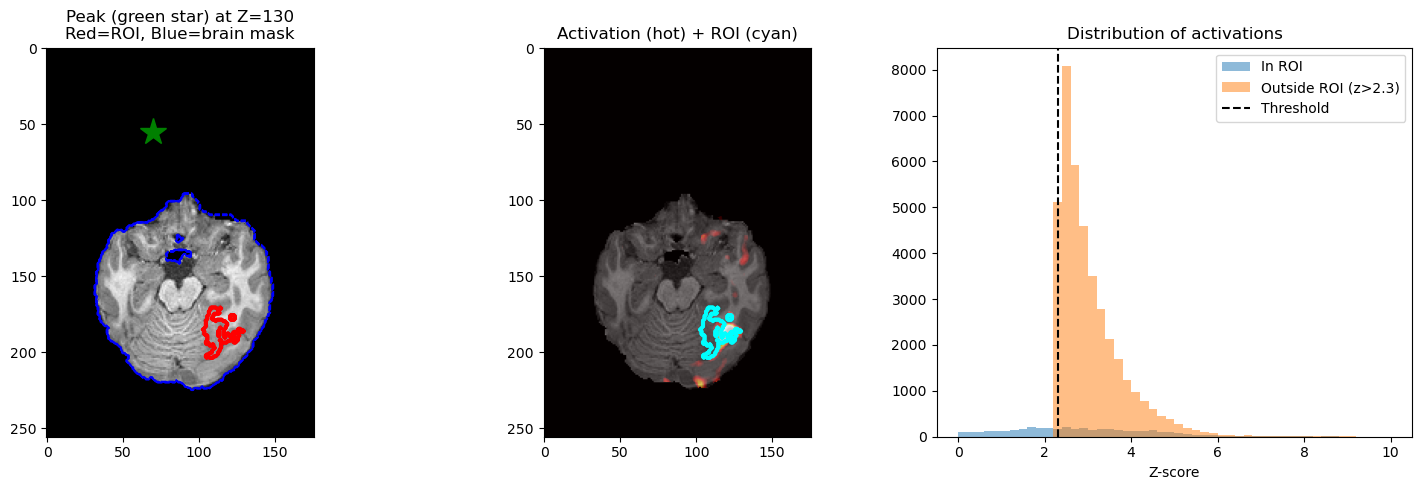

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

subject = 'sub-021'
session = '01'
base = '/user_data/csimmon2/long_pt'

# Load brain mask
brain_mask = nib.load(f'{base}/{subject}/ses-{session}/anat/{subject}_ses-{session}_T1w_brain_mask.nii.gz')
mask_data = brain_mask.get_fdata()

# Load ROI
roi = nib.load(f'{base}/{subject}/ses-{session}/ROIs/r_VOTC_FG_OTS_mask.nii.gz')
roi_data = roi.get_fdata()

# Load activation
zstat = nib.load(f'{base}/{subject}/ses-{session}/derivatives/fsl/loc/HighLevel.gfeat/cope13.feat/stats/zstat1.nii.gz')
z_data = zstat.get_fdata()

print("Checking alignment...")
print(f"Brain mask shape: {mask_data.shape}")
print(f"ROI shape: {roi_data.shape}")
print(f"Zstat shape: {z_data.shape}")

if mask_data.shape != z_data.shape:
    print("\n⚠️  WARNING: Brain mask and zstat have different shapes!")
    print("Registration issue detected!")
else:
    # Mask the zstat to only brain voxels
    z_masked = z_data * (mask_data > 0)
    
    # Find peak WITHIN brain
    peak_coords = np.unravel_index(np.argmax(z_masked), z_masked.shape)
    peak_value = z_masked[peak_coords]
    
    print(f"\nPeak face-word activation (WITHIN BRAIN):")
    print(f"  Coordinates: {peak_coords}")
    print(f"  Z-value: {peak_value:.2f}")
    print(f"  In brain mask? {mask_data[peak_coords] > 0}")
    print(f"  In ROI? {roi_data[peak_coords] > 0}")
    
    # How much activation is in the brain at all?
    z_thresh = 2.3
    activated = z_masked > z_thresh
    n_activated = np.sum(activated)
    
    print(f"\nActivated voxels in brain (z>{z_thresh}): {n_activated}")
    
    # How much overlaps with ROI?
    activated_in_roi = activated & (roi_data > 0)
    n_in_roi = np.sum(activated_in_roi)
    
    print(f"Activated voxels in ROI: {n_in_roi} ({n_in_roi/n_activated*100:.1f}%)")
    
    # Visualize with brain mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    anat = nib.load(f'{base}/{subject}/ses-{session}/anat/{subject}_ses-{session}_T1w_brain.nii.gz')
    anat_data = anat.get_fdata()
    
    z_slice = peak_coords[2]
    
    axes[0].imshow(np.rot90(anat_data[:, :, z_slice]), cmap='gray')
    axes[0].contour(np.rot90(roi_data[:, :, z_slice]), colors='red', linewidths=2)
    axes[0].contour(np.rot90(mask_data[:, :, z_slice]), colors='blue', linewidths=1, linestyles='dashed')
    axes[0].plot(peak_coords[1], anat_data.shape[0] - peak_coords[0], 'g*', markersize=20)
    axes[0].set_title(f'Peak (green star) at Z={z_slice}\nRed=ROI, Blue=brain mask')
    
    # Show activation overlay
    z_slice_data = z_masked[:, :, z_slice]
    axes[1].imshow(np.rot90(anat_data[:, :, z_slice]), cmap='gray')
    axes[1].imshow(np.rot90(z_slice_data), cmap='hot', alpha=0.5, vmin=z_thresh, vmax=6)
    axes[1].contour(np.rot90(roi_data[:, :, z_slice]), colors='cyan', linewidths=2)
    axes[1].set_title('Activation (hot) + ROI (cyan)')
    
    # Histogram of z-values in ROI vs outside
    z_in_roi = z_masked[roi_data > 0]
    z_outside_roi = z_masked[(mask_data > 0) & (roi_data == 0)]
    
    axes[2].hist(z_in_roi[z_in_roi > 0], bins=50, alpha=0.5, label='In ROI', range=(0, 10))
    axes[2].hist(z_outside_roi[z_outside_roi > z_thresh], bins=50, alpha=0.5, label='Outside ROI (z>2.3)', range=(0, 10))
    axes[2].axvline(z_thresh, color='k', linestyle='--', label='Threshold')
    axes[2].legend()
    axes[2].set_xlabel('Z-score')
    axes[2].set_title('Distribution of activations')
    
    plt.tight_layout()
    plt.savefig(f'{base}/analyses/{subject}_peak_vs_roi_masked.png', dpi=150)
    print(f"\nSaved: {base}/analyses/{subject}_peak_vs_roi_masked.png")

In [3]:
import nibabel as nib
import numpy as np

subject = 'sub-021'
session = '01'
base = '/user_data/csimmon2/long_pt'

# Load from HighLevel (in anatomical space)
roi = nib.load(f'{base}/{subject}/ses-{session}/ROIs/r_VOTC_FG_OTS_mask.nii.gz')
zstat_fw = nib.load(f'{base}/{subject}/ses-{session}/derivatives/fsl/loc/HighLevel.gfeat/cope13.feat/stats/zstat1.nii.gz')

roi_data = roi.get_fdata()
z_fw = zstat_fw.get_fdata()

# Extract just the voxels WITHIN the ROI
z_in_roi = z_fw[roi_data > 0]

print("="*60)
print(f"WITHIN YOUR FG/OTS ROI ({np.sum(roi_data > 0)} voxels):")
print("="*60)
print(f"Face-Word z-scores:")
print(f"  Mean: {z_in_roi.mean():.3f}")
print(f"  Std: {z_in_roi.std():.3f}")
print(f"  Max: {z_in_roi.max():.3f}")
print(f"  Min: {z_in_roi.min():.3f}")
print(f"  Median: {np.median(z_in_roi):.3f}")

# How many voxels are significantly activated?
thresholds = [2.3, 3.0, 4.0]
for thresh in thresholds:
    n_above = np.sum(z_in_roi > thresh)
    pct = n_above / len(z_in_roi) * 100
    print(f"  Voxels z>{thresh}: {n_above} ({pct:.1f}%)")

# This is what Liu extracted - the distribution of face-word scores in ROI
print(f"\nThis distribution (mean={z_in_roi.mean():.3f}) is what gets tracked longitudinally")
print(f"Your current extraction showed mean t=1.90 for ses-01")
print(f"z-stat and t-stat should be very similar with high df")

WITHIN YOUR FG/OTS ROI (5474 voxels):
Face-Word z-scores:
  Mean: 1.900
  Std: 2.360
  Max: 9.068
  Min: -4.345
  Median: 2.018
  Voxels z>2.3: 2466 (45.0%)
  Voxels z>3.0: 1815 (33.2%)
  Voxels z>4.0: 1043 (19.1%)

This distribution (mean=1.900) is what gets tracked longitudinally
Your current extraction showed mean t=1.90 for ses-01
z-stat and t-stat should be very similar with high df


In [4]:
import nibabel as nib
import numpy as np

subject = 'sub-021'
session = '01'
base = '/user_data/csimmon2/long_pt'

# Load ROI (in anatomical space)
roi = nib.load(f'{base}/{subject}/ses-{session}/ROIs/r_VOTC_FG_OTS_mask.nii.gz')
roi_data = roi.get_fdata()

print(f"FG/OTS ROI: {np.sum(roi_data > 0)} voxels")

# Check HighLevel (which averages across runs and is in anatomical space)
# cope10 = face>scrambled, cope12 = word>scrambled

for cope, name in [(10, 'Face>Scrambled'), (12, 'Word>Scrambled')]:
    zstat_file = f'{base}/{subject}/ses-{session}/derivatives/fsl/loc/HighLevel.gfeat/cope{cope}.feat/stats/zstat1.nii.gz'
    
    if os.path.exists(zstat_file):
        zstat = nib.load(zstat_file)
        z_data = zstat.get_fdata()
        z_in_roi = z_data[roi_data > 0]
        
        print(f"\n{name} within FG/OTS:")
        print(f"  Mean: {z_in_roi.mean():.3f}")
        print(f"  Voxels z>2.3: {np.sum(z_in_roi > 2.3)} ({np.sum(z_in_roi > 2.3)/len(z_in_roi)*100:.1f}%)")

FG/OTS ROI: 5474 voxels

Face>Scrambled within FG/OTS:
  Mean: 4.815
  Voxels z>2.3: 3717 (67.9%)

Word>Scrambled within FG/OTS:
  Mean: 0.178
  Voxels z>2.3: 706 (12.9%)


In [5]:
import nibabel as nib
import numpy as np
import os

base = '/user_data/csimmon2/long_pt'

subjects_config = {
    'sub-004': {'hemi': 'l', 'patient': 'UD (left preserved)'},
    'sub-021': {'hemi': 'r', 'patient': 'TC (right preserved)'},
    'sub-007': {'hemi': 'l', 'patient': 'OT (left preserved, control)'}
}

print("="*70)
print("ROI VALIDATION: Face vs Word Selectivity in FG/OTS")
print("="*70)

for subject, config in subjects_config.items():
    session = '01'
    hemi = config['hemi']
    
    print(f"\n{subject} - {config['patient']}")
    print("-"*70)
    
    # Load ROI
    roi_file = f'{base}/{subject}/ses-{session}/ROIs/{hemi}_VOTC_FG_OTS_mask.nii.gz'
    
    if not os.path.exists(roi_file):
        print(f"  ⚠️  ROI not found: {roi_file}")
        continue
    
    roi = nib.load(roi_file)
    roi_data = roi.get_fdata()
    n_voxels = np.sum(roi_data > 0)
    
    print(f"  FG/OTS ROI: {n_voxels} voxels")
    
    # Check face>scrambled and word>scrambled
    for cope, name in [(10, 'Face>Scrambled'), (12, 'Word>Scrambled')]:
        zstat_file = f'{base}/{subject}/ses-{session}/derivatives/fsl/loc/HighLevel.gfeat/cope{cope}.feat/stats/zstat1.nii.gz'
        
        if not os.path.exists(zstat_file):
            print(f"    ⚠️  {name}: File not found")
            continue
        
        zstat = nib.load(zstat_file)
        z_data = zstat.get_fdata()
        z_in_roi = z_data[roi_data > 0]
        
        n_activated = np.sum(z_in_roi > 2.3)
        pct_activated = n_activated / n_voxels * 100
        
        print(f"  {name}:")
        print(f"    Mean z: {z_in_roi.mean():.3f}")
        print(f"    Std z: {z_in_roi.std():.3f}")
        print(f"    Voxels z>2.3: {n_activated} ({pct_activated:.1f}%)")

print("\n" + "="*70)
print("EXPECTATIONS:")
print("="*70)
print("sub-004 (UD, LEFT preserved): Should have HIGH word selectivity (left-lateralized)")
print("sub-021 (TC, RIGHT preserved): Should have LOW word selectivity")
print("sub-007 (OT, LEFT preserved): Should have HIGH word selectivity")

ROI VALIDATION: Face vs Word Selectivity in FG/OTS

sub-004 - UD (left preserved)
----------------------------------------------------------------------
  FG/OTS ROI: 7590 voxels
  Face>Scrambled:
    Mean z: -0.631
    Std z: 1.974
    Voxels z>2.3: 570 (7.5%)
  Word>Scrambled:
    Mean z: -2.004
    Std z: 1.973
    Voxels z>2.3: 125 (1.6%)

sub-021 - TC (right preserved)
----------------------------------------------------------------------
  FG/OTS ROI: 5474 voxels
  Face>Scrambled:
    Mean z: 4.815
    Std z: 3.999
    Voxels z>2.3: 3717 (67.9%)
  Word>Scrambled:
    Mean z: 0.178
    Std z: 1.958
    Voxels z>2.3: 706 (12.9%)

sub-007 - OT (left preserved, control)
----------------------------------------------------------------------
  FG/OTS ROI: 6937 voxels
  Face>Scrambled:
    Mean z: 0.266
    Std z: 4.567
    Voxels z>2.3: 2078 (30.0%)
  Word>Scrambled:
    Mean z: -2.054
    Std z: 4.393
    Voxels z>2.3: 1014 (14.6%)

EXPECTATIONS:
sub-004 (UD, LEFT preserved): Should h

Saved visualization

ROI Centers (voxel coordinates):
sub-004: (54, 78, 127)
sub-021: (119, 70, 131)
sub-007: (52, 62, 134)


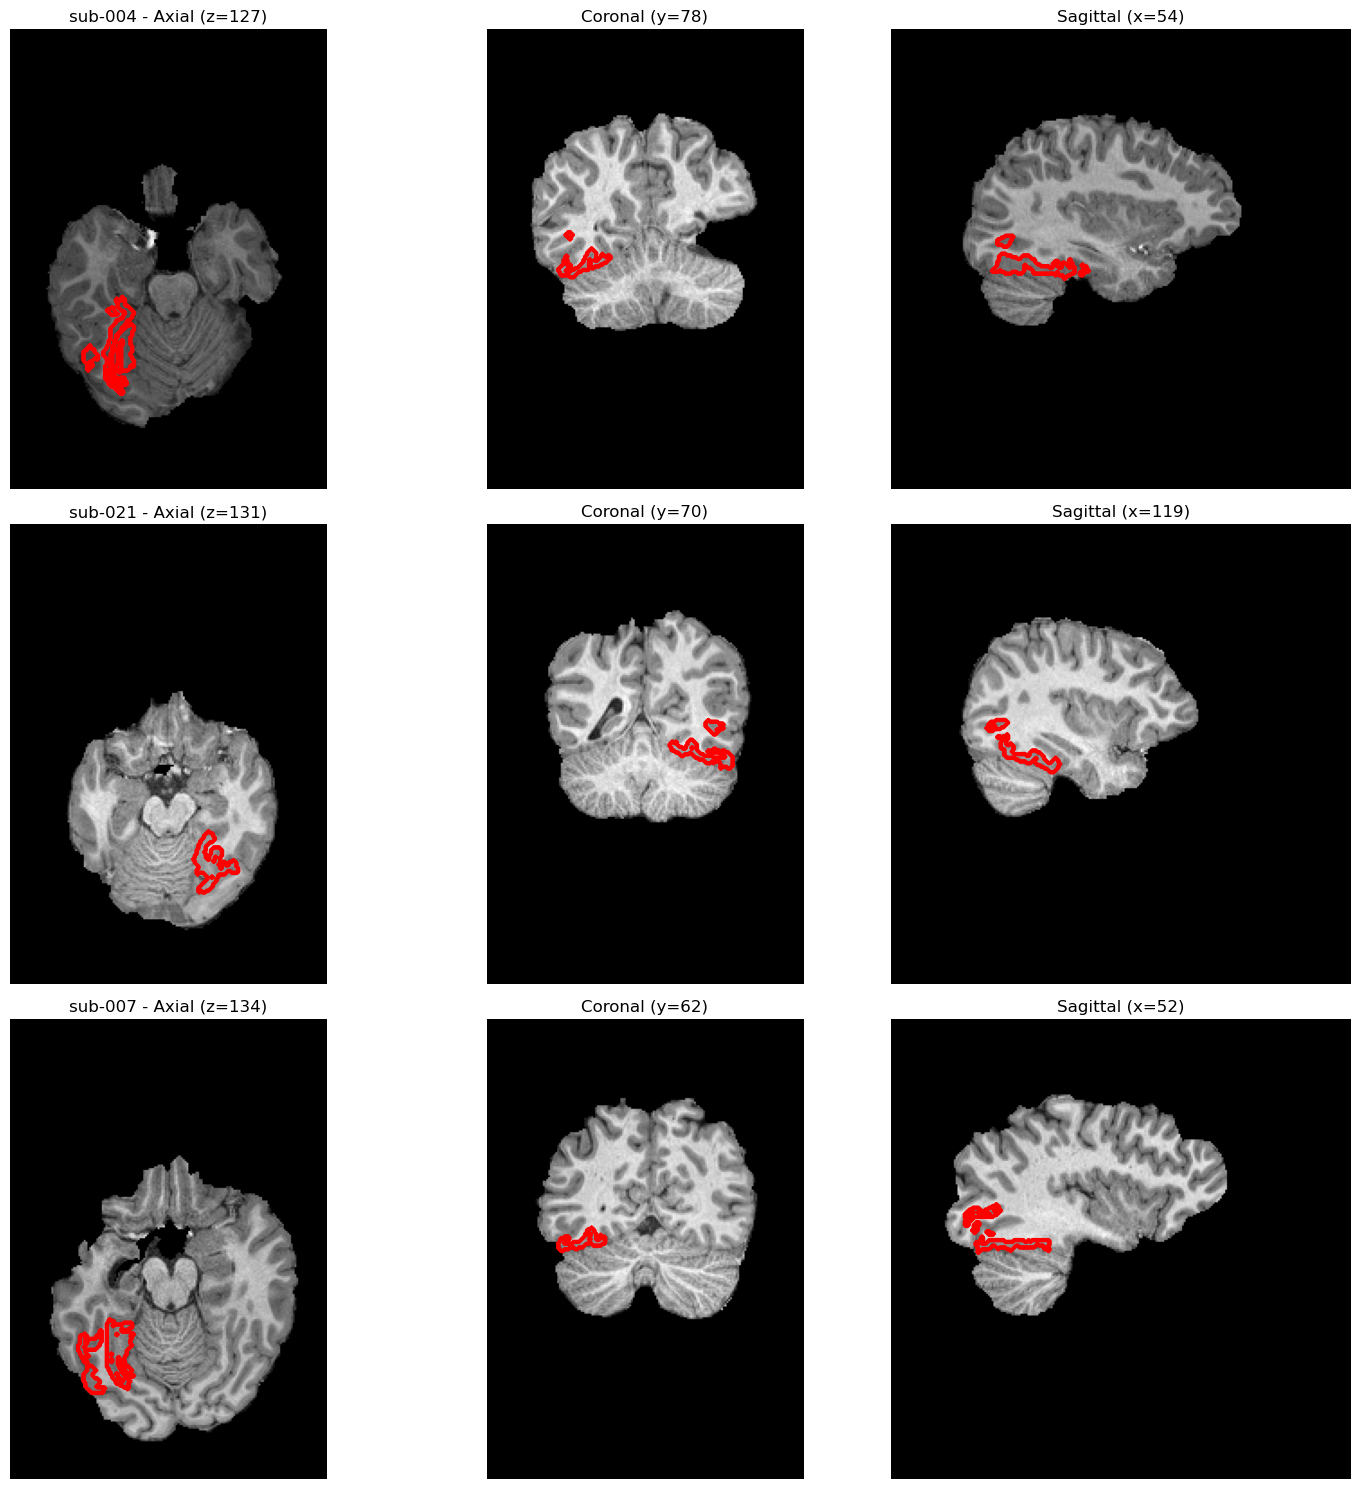

In [7]:
from nilearn import plotting
import nibabel as nib
import matplotlib.pyplot as plt

base = '/user_data/csimmon2/long_pt'

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for row, (subject, hemi) in enumerate([('sub-004', 'l'), ('sub-021', 'r'), ('sub-007', 'l')]):
    session = '01'
    
    # Load data
    anat = nib.load(f'{base}/{subject}/ses-{session}/anat/{subject}_ses-{session}_T1w_brain.nii.gz')
    roi = nib.load(f'{base}/{subject}/ses-{session}/ROIs/{hemi}_VOTC_FG_OTS_mask.nii.gz')
    
    # Find ROI center
    roi_data = roi.get_fdata()
    coords = np.where(roi_data > 0)
    center_x = int(np.mean(coords[0]))
    center_y = int(np.mean(coords[1]))
    center_z = int(np.mean(coords[2]))
    
    anat_data = anat.get_fdata()
    
    # Axial
    axes[row, 0].imshow(np.rot90(anat_data[:, :, center_z]), cmap='gray')
    axes[row, 0].contour(np.rot90(roi_data[:, :, center_z]), colors='red', linewidths=2)
    axes[row, 0].set_title(f'{subject} - Axial (z={center_z})')
    axes[row, 0].axis('off')
    
    # Coronal
    axes[row, 1].imshow(np.rot90(anat_data[:, center_y, :]), cmap='gray')
    axes[row, 1].contour(np.rot90(roi_data[:, center_y, :]), colors='red', linewidths=2)
    axes[row, 1].set_title(f'Coronal (y={center_y})')
    axes[row, 1].axis('off')
    
    # Sagittal
    axes[row, 2].imshow(np.rot90(anat_data[center_x, :, :]), cmap='gray')
    axes[row, 2].contour(np.rot90(roi_data[center_x, :, :]), colors='red', linewidths=2)
    axes[row, 2].set_title(f'Sagittal (x={center_x})')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.savefig(f'{base}/analyses/all_subjects_roi_location.png', dpi=150)
print("Saved visualization")

# Print ROI centers
print("\nROI Centers (voxel coordinates):")
for subject, hemi in [('sub-004', 'l'), ('sub-021', 'r'), ('sub-007', 'l')]:
    roi = nib.load(f'{base}/{subject}/ses-{session}/ROIs/{hemi}_VOTC_FG_OTS_mask.nii.gz')
    roi_data = roi.get_fdata()
    coords = np.where(roi_data > 0)
    center = (int(np.mean(coords[0])), int(np.mean(coords[1])), int(np.mean(coords[2])))
    print(f"{subject}: {center}")